In [3]:
#|default_exp models.InceptionTime

# InceptionTime

>An ensemble of deep Convolutional Neural Network (CNN) models, inspired by the Inception-v4 architecture

This is an unofficial PyTorch implementation created by Ignacio Oguiza (timeseriesAI@gmail.com) based on:

Fawaz, H. I., Lucas, B., Forestier, G., Pelletier, C., Schmidt, D. F., Weber, J. & Petitjean, F. (2019). 
<span style="color:dodgerblue">**InceptionTime: Finding AlexNet for Time Series Classification**</span>. arXiv preprint arXiv:1909.04939. 

Official InceptionTime tensorflow implementation: https://github.com/hfawaz/InceptionTime

In [4]:
#|export
from tsai.imports import *
from tsai.models.layers import *
from torchinfo import summary



/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import signal

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
torch.version.cuda

'11.6'

In [8]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

In [9]:
# hyper parameter
num_classes = 30
batch_size = 64
learning_rate = 0.001
num_epochs = 10
down_ratio = 8
sequence_len = 2000 * 5 // down_ratio # default 2000Hz
overlap = int(sequence_len * 0.3)

data preparation

In [10]:
radar_frame_list = []
scaler = MinMaxScaler((-1, 1)) # or StandardScaler

for i in range(1, num_classes + 1):
    # wave_2d = [] # input need to be 2d?
    file_path = "./data/radar_%02d.csv" % i # or ./data/radar_%02d
    radar_frame = pd.read_csv(file_path)
    wave = radar_frame.to_numpy().flatten()
    wave = signal.decimate(wave, down_ratio) # down sampling
    
    end = len(wave)
    n = 0
    n_stop = sequence_len
    wave_segments = []

    while n_stop < end:
        n_start = 0 + ((sequence_len - 1) - (overlap - 1)) * n
        n_stop = n_start + sequence_len
        tmp = []
        seg = wave[n_start:n_stop].copy()
        wave_segments.append([seg])
        n += 1
    
    radar_frame_list.append(wave_segments)

data_df = pd.DataFrame(radar_frame_list)

prepare labels

In [11]:
labels = []
for i in range(len(radar_frame_list)):
    for j in range(len(radar_frame_list[i])):
        labels.append(i)

labels_series = pd.Series(labels)

Remove None & len < sequence_len(=1250) against data and labels

In [12]:
tmp = data_df.to_numpy().flatten().copy()
data_series = pd.Series(tmp).dropna() # remove None (keys are as they are)
tmp = data_series.to_numpy().flatten()

tmp_labels = labels_series.to_numpy().flatten()
# len(tmp) = 5442 (30人分のデータ)
# len(tmp[0]) = 1 (in_channelが1のため)
# len(tmp[0][0]) = 1250 (sequence_len)

for i in reversed(range(len(tmp))):
  if len(tmp[i][0]) != sequence_len:
    print(i, len(tmp[i][0]))
    tmp = np.delete(tmp, i)
    tmp_labels = np.delete(tmp_labels, i)

data_series = pd.Series(tmp)
labels_series = pd.Series(tmp_labels)
labels_tensor = torch.tensor(labels_series)
data_series.shape, labels_tensor, labels_tensor.shape

5441 900
5262 838
5086 725
4911 1219
4732 507
4497 1107
4321 1244
4147 838
3953 438
3764 1232
3589 788
3406 1150
3234 619
3052 1188
2880 388
2705 1113
2348 1157
2141 1113
1956 1232
1771 532
1588 475
1402 644
1225 1232
1044 482
869 1150
695 1144
523 713
351 713
173 525


((5413,), tensor([ 0,  0,  0,  ..., 29, 29, 29]), torch.Size([5413]))

In [13]:
#|export
# This is an unofficial PyTorch implementation by Ignacio Oguiza - timeseriesAI@gmail.com based on:

# Fawaz, H. I., Lucas, B., Forestier, G., Pelletier, C., Schmidt, D. F., Weber, J., ... & Petitjean, F. (2019). 
# InceptionTime: Finding AlexNet for Time Series Classification. arXiv preprint arXiv:1909.04939.
# Official InceptionTime tensorflow implementation: https://github.com/hfawaz/InceptionTime

class InceptionModule(Module):
    def __init__(self, ni, nf, ks=40, bottleneck=True):
        ks = [ks // (2**i) for i in range(3)]
        ks = [k if k % 2 != 0 else k - 1 for k in ks]  # ensure odd ks
        bottleneck = bottleneck if ni > 1 else False
        self.bottleneck = Conv1d(ni, nf, 1, bias=False) if bottleneck else noop
        self.convs = nn.ModuleList([Conv1d(nf if bottleneck else ni, nf, k, bias=False) for k in ks])
        self.maxconvpool = nn.Sequential(*[nn.MaxPool1d(3, stride=1, padding=1), Conv1d(ni, nf, 1, bias=False)])
        self.concat = Concat()
        self.bn = BN1d(nf * 4)
        self.act = nn.ReLU()

    def forward(self, x):
        input_tensor = x
        x = self.bottleneck(input_tensor)
        x = self.concat([l(x) for l in self.convs] + [self.maxconvpool(input_tensor)])
        return self.act(self.bn(x))


@delegates(InceptionModule.__init__)
class InceptionBlock(Module):
    def __init__(self, ni, nf=32, residual=True, depth=6, **kwargs):
        self.residual, self.depth = residual, depth
        self.inception, self.shortcut = nn.ModuleList(), nn.ModuleList()
        for d in range(depth):
            self.inception.append(InceptionModule(ni if d == 0 else nf * 4, nf, **kwargs))
            if self.residual and d % 3 == 2: 
                n_in, n_out = ni if d == 2 else nf * 4, nf * 4
                self.shortcut.append(BN1d(n_in) if n_in == n_out else ConvBlock(n_in, n_out, 1, act=None))
        self.add = Add()
        self.act = nn.ReLU()
        
    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inception[d](x)
            if self.residual and d % 3 == 2: res = x = self.act(self.add(x, self.shortcut[d//3](res)))
        return x

    
@delegates(InceptionModule.__init__)
class InceptionTime(Module):
    def __init__(self, c_in, c_out, seq_len=None, nf=32, nb_filters=None, **kwargs):
        nf = ifnone(nf, nb_filters) # for compatibility
        self.inceptionblock = InceptionBlock(c_in, nf, **kwargs) # c_in is input channel num of conv1d
        self.gap = GAP1d(1)
        self.fc = nn.Linear(nf * 4, c_out) # c_out is 1d output size 

    def forward(self, x):
        x = self.inceptionblock(x)
        x = self.gap(x)
        x = self.fc(x)
        return x

In [14]:
from tsai.models.utils import count_parameters

In [15]:
bs = 16
vars = 1
seq_len = 12
c_out = 2
xb = torch.rand(bs, vars, seq_len)
test_eq(InceptionTime(vars,c_out)(xb).shape, [bs, c_out])
test_eq(InceptionTime(vars,c_out, bottleneck=False)(xb).shape, [bs, c_out])
test_eq(InceptionTime(vars,c_out, residual=False)(xb).shape, [bs, c_out])
test_eq(count_parameters(InceptionTime(3, 2)), 455490)

In [16]:
model = InceptionTime(1, 30)
summary(model)

Layer (type:depth-idx)                        Param #
InceptionTime                                 --
├─InceptionBlock: 1-1                         --
│    └─ModuleList: 2-1                        --
│    │    └─InceptionModule: 3-1              2,432
│    │    └─InceptionModule: 3-2              77,056
│    │    └─InceptionModule: 3-3              77,056
│    │    └─InceptionModule: 3-4              77,056
│    │    └─InceptionModule: 3-5              77,056
│    │    └─InceptionModule: 3-6              77,056
│    └─ModuleList: 2-2                        --
│    │    └─ConvBlock: 3-7                    384
│    │    └─BatchNorm1d: 3-8                  256
│    └─Add: 2-3                               --
│    └─ReLU: 2-4                              --
├─GAP1d: 1-2                                  --
│    └─AdaptiveAvgPool1d: 2-5                 --
│    └─Flatten: 2-6                           --
├─Linear: 1-3                                 3,870
Total params: 392,222
Trainable para

In [17]:
class MyDataset(Dataset):
    def __init__(self, dataset, labels, root_dir, transform=None) -> None:
        # super().__init__()
        self.radar_heartbeat = dataset
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()
        
        onehot_label = torch.eye(num_classes)[self.labels[idx] - 1] # one hot encodingは不要らしい　精度悪い場合試す必要あり
        # one_hot = torch.nn.functional.one_hot(self.labels, num_classes=num_classes)
        return torch.tensor(self.radar_heartbeat[idx]), self.labels[idx] # labels is already tensor (converted in preparation phase)
        # return torch.tensor(self.radar_heartbeat[idx]), onehot_label

    def __len__(self):
        return len(self.radar_heartbeat)


dataset = MyDataset(data_series, labels_tensor, "./data/", transform=transforms.ToTensor())

In [18]:
dataset[0]

/tmp/ipykernel_748/3033810394.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.tensor(self.radar_heartbeat[idx]), self.labels[idx] # labels is already tensor (converted in preparation phase)


(tensor([[-1.0218e-04, -9.2261e-05, -8.1324e-05,  ..., -1.0458e-04,
          -1.0550e-04, -1.0560e-04]], dtype=torch.float64),
 tensor(0))

In [19]:
len(dataset[0][0][0])

1250

In [20]:
train_size = int(0.8 * len(data_series.values))
test_size = len(data_series.values) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size]) # check whether each data and label set is synchronized 
print(f"full: {len(dataset)} -> train: {len(train_set)}, test: {len(test_set)}")

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

full: 5413 -> train: 4330, test: 1083


In [21]:
model = InceptionTime(1, num_classes)
# model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (signals, labels) in enumerate(train_loader):
    signals = torch.tensor(signals)
    signals = signals.float()
    # signals = signals.to(device)
    # labels = labels.to(device)

    # print(signals.size())
    outputs = model(signals)
    # print(outputs)
    loss = criterion(outputs, labels) # will check the shapes of outputs and labels

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i + 1) % 12 == 0:
      print(f'Epoch [{epoch+1}/`{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

/tmp/ipykernel_748/3285515412.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)


Epoch [1/`10], Step [12/68], Loss: 3.0278
Epoch [1/`10], Step [24/68], Loss: 2.9737
Epoch [1/`10], Step [36/68], Loss: 2.6401
Epoch [1/`10], Step [48/68], Loss: 2.6509
Epoch [1/`10], Step [60/68], Loss: 2.4009
Epoch [2/`10], Step [12/68], Loss: 2.1043
Epoch [2/`10], Step [24/68], Loss: 2.0686
Epoch [2/`10], Step [36/68], Loss: 1.9590
Epoch [2/`10], Step [48/68], Loss: 1.7422
Epoch [2/`10], Step [60/68], Loss: 1.5151
Epoch [3/`10], Step [12/68], Loss: 1.2232
Epoch [3/`10], Step [24/68], Loss: 1.0974
Epoch [3/`10], Step [36/68], Loss: 1.0964
Epoch [3/`10], Step [48/68], Loss: 0.9563
Epoch [3/`10], Step [60/68], Loss: 0.8552
Epoch [4/`10], Step [12/68], Loss: 0.5818
Epoch [4/`10], Step [24/68], Loss: 0.6023
Epoch [4/`10], Step [36/68], Loss: 0.4469
Epoch [4/`10], Step [48/68], Loss: 0.5921
Epoch [4/`10], Step [60/68], Loss: 0.5434
Epoch [5/`10], Step [12/68], Loss: 0.2868
Epoch [5/`10], Step [24/68], Loss: 0.2336
Epoch [5/`10], Step [36/68], Loss: 0.2092
Epoch [5/`10], Step [48/68], Loss:

In [23]:
# For Confusion Matrix
predicted_lists = np.zeros(0, dtype=np.int64)
one_hot_labels_list = np.zeros(0, dtype=np.int64)

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  softmax = nn.Softmax()
  for i, (signals, one_hot_labels) in enumerate(test_loader):
    signals = torch.tensor(signals)
    signals = signals.float()
    # signals = signals.to(device)
    # one_hot_labels = one_hot_labels.to(device)
    # print(len(one_hot_labels))
    outputs = model(signals)
    for j, out in enumerate(outputs):
      outputs[j] = softmax(out)

    _, predicted = torch.max(outputs.data, 1) # predicted per batch size

    n_samples += one_hot_labels.size(0) # add batch_size
    n_correct += (predicted == one_hot_labels).sum().item()
    
    predicted_cp = predicted.to('cpu').detach().numpy().copy()
    one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
    predicted_lists = np.concatenate([predicted_lists, predicted_cp])
    one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
    
    acc = 100.0 * n_correct / n_samples
    print(f'{n_correct} / {n_samples} = Acc: {acc} %')

/tmp/ipykernel_748/916041703.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)


64 / 64 = Acc: 100.0 %
128 / 128 = Acc: 100.0 %
191 / 192 = Acc: 99.47916666666667 %
255 / 256 = Acc: 99.609375 %
319 / 320 = Acc: 99.6875 %
382 / 384 = Acc: 99.47916666666667 %
445 / 448 = Acc: 99.33035714285714 %
508 / 512 = Acc: 99.21875 %
572 / 576 = Acc: 99.30555555555556 %
636 / 640 = Acc: 99.375 %
699 / 704 = Acc: 99.28977272727273 %
763 / 768 = Acc: 99.34895833333333 %
827 / 832 = Acc: 99.39903846153847 %
890 / 896 = Acc: 99.33035714285714 %
954 / 960 = Acc: 99.375 %
1017 / 1024 = Acc: 99.31640625 %
1076 / 1083 = Acc: 99.35364727608496 %


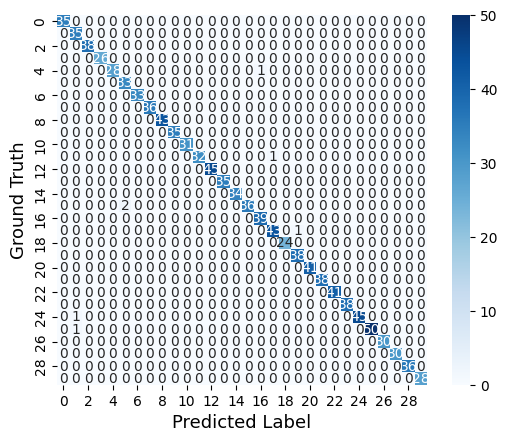

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(one_hot_labels_list, predicted_lists)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("Ground Truth", fontsize=13)
plt.savefig('sklearn_confusion_matrix.png')

In [25]:
# np.concatenate(predicted_lists, predicted_cp)
predicted_lists, predicted_cp

(array([29, 14,  8, ..., 18,  5,  2]),
 array([29, 12,  7,  9, 21, 16,  5, 17,  5, 24, 20,  4,  1, 22,  9, 15, 14,
        12,  6,  8, 22,  2,  9,  2, 18, 16,  5,  2, 23, 25,  1,  0, 29,  3,
        14, 19, 22, 28,  2,  9,  0, 12, 27, 27, 11, 17, 19,  0,  1,  1, 29,
        20, 16, 20, 15, 19, 18,  5,  2]))

In [26]:
predicted_cp, one_hot_labels_cp
a = []
a + predicted_cp.tolist() # 足し算でリストの結合できる（中身のみ後ろに追加できる）


[29,
 12,
 7,
 9,
 21,
 16,
 5,
 17,
 5,
 24,
 20,
 4,
 1,
 22,
 9,
 15,
 14,
 12,
 6,
 8,
 22,
 2,
 9,
 2,
 18,
 16,
 5,
 2,
 23,
 25,
 1,
 0,
 29,
 3,
 14,
 19,
 22,
 28,
 2,
 9,
 0,
 12,
 27,
 27,
 11,
 17,
 19,
 0,
 1,
 1,
 29,
 20,
 16,
 20,
 15,
 19,
 18,
 5,
 2]

In [27]:
predicted, predicted.shape, one_hot_labels, one_hot_labels.shape

(TensorBase([29, 12,  7,  9, 21, 16,  5, 17,  5, 24, 20,  4,  1, 22,  9, 15, 14,
             12,  6,  8, 22,  2,  9,  2, 18, 16,  5,  2, 23, 25,  1,  0, 29,  3,
             14, 19, 22, 28,  2,  9,  0, 12, 27, 27, 11, 17, 19,  0,  1,  1, 29,
             20, 16, 20, 15, 19, 18,  5,  2]),
 torch.Size([59]),
 tensor([29, 12,  7,  9, 21, 16,  5, 17,  5, 24, 20,  4,  1, 22,  9, 15, 14, 12,
          6,  8, 22,  2,  9,  2, 18, 16,  5,  2, 23, 25,  1,  0, 29,  3, 14, 19,
         22, 28,  2,  9,  0, 12, 27, 27, 11, 17, 19,  0,  1,  1, 29, 20, 16, 20,
         15, 19, 18,  5,  2]),
 torch.Size([59]))

In [28]:
data, label = next(iter(dataset))
data.size()

torch.Size([1, 1250])

In [29]:
signals.shape

torch.Size([59, 1, 1250])

In [30]:
outputs, labels, loss

(TensorBase([[3.5411e-07, 5.7667e-04, 2.2809e-04,  ..., 7.2073e-05,
              3.6173e-05, 9.8739e-01],
             [4.5063e-05, 2.8571e-03, 2.8689e-05,  ..., 3.6860e-05,
              1.9275e-05, 4.0820e-03],
             [3.2798e-08, 9.4389e-05, 8.2593e-04,  ..., 5.4117e-03,
              1.1313e-04, 1.9164e-05],
             ...,
             [1.4057e-07, 2.9375e-05, 2.4010e-06,  ..., 2.1683e-05,
              8.1785e-04, 9.1404e-04],
             [4.3889e-05, 2.0513e-04, 6.3460e-07,  ..., 2.1091e-06,
              1.9601e-07, 1.6772e-04],
             [1.7748e-07, 9.9975e-07, 9.9614e-01,  ..., 5.2329e-04,
              4.4666e-05, 1.2107e-04]]),
 tensor([ 4, 29,  5,  5,  5, 26,  5, 28, 21, 22, 25, 25, 16,  9,  9,  1,  2, 16,
          0, 29,  9, 26, 17,  5,  1,  7, 14,  8, 23, 12, 17, 17, 19,  5, 29, 25,
         25, 29,  3,  5,  6, 29]),
 TensorBase(0.0569, grad_fn=<AliasBackward0>))

In [31]:
min(labels), max(labels)

(tensor(0), tensor(29))